In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
import pickle
import tensorflow as tf
import tensorflow_io as tfio
import os
import sys
from numpy import argmax

sys.path.insert(0, '../VisualizationTools')
import get_data_from_XML, get_gt, getUID, roi2rect, utils, visualization

from sklearn.metrics import f1_score, mean_squared_error, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, Input
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#Convert a numpy 3d array of a bitmap of an rgb image to grayscale
#using the formula (0.3 * R) + (0.59 * G) + (0.11 * B) 
def rgb_bmp_togray(imgbmp):
    r = imgbmp[:,:,0]
    g = imgbmp[:,:,1]
    b = imgbmp[:,:,2]
    graybmp = np.multiply(0.3*r, 0.59*g)
    graybmp = np.multiply(graybmp, .11*b)
    
    return graybmp

#Intersection over union calculation given two bounding boxes
def IOU(bbox1, bbox2):
    xmin1, ymin1, xmax1, ymax1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    xmin2, ymin2, xmax2, ymax2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    x_intersection = 0
    if xmin1 <= xmax2 and xmin2 <= xmax1:
        x_intersection = min(xmax1, xmax2) - max(xmin1, xmin2)
        
    y_intersection = 0
    if ymin1 <= ymax2 and ymin2 <= ymax1:
        y_intersection = min(ymax1, ymax2) - max(ymin1, ymin2)
    
    intersection = x_intersection * y_intersection
    
    if intersection == 0:
        return 0
    
    union = (xmax1-xmin1)*(ymax1-ymin1) + (xmax2-xmin2)*(ymax2-ymin2) - intersection
    
    return intersection/union
    

    return I / U

dicom_path = '../images/smallTraining/'
annotation_path = '../annot/Annotation/'

anfilenames = os.listdir(annotation_path)
lungfilenames = os.listdir(dicom_path)
num_classes = 4
xtotal = []
ybox = []
yclass = []
for aname in anfilenames:
    #if np.random.random() > .1:
    #    continue
    anpath = annotation_path + aname
    lungpath = dicom_path + "Lung_Dx-" + aname
    if not os.path.isdir(lungpath):
        print("missing: ", lungpath)
        continue
    lungs = getUID.getUID_path(lungpath)
    annotations = get_data_from_XML.XML_preprocessor(anpath, num_classes=num_classes).data
    for k, v in annotations.items():
        
        key = k[:-4]
        if key not in lungs:
            print("missing key: ", k)
            continue
        dcm_path, dcm_name = lungs[k[:-4]]
        matrix, frame_num, width, height, ch = utils.loadFile(dcm_path)
        img_bitmap = utils.MatrixToImage(matrix[0], ch)
        xbmp = img_bitmap
        if len(img_bitmap.shape) > 2: #assume bitmap is rgb
            xbmp = rgb_bmp_togray(img_bitmap)
        xbmp = xbmp.reshape(np.prod(xbmp.shape))/255
        xtotal.append(xbmp)

        #extract xmin, ymin, xmax, ymax in that order
        ybox.append(np.array([v[0][0], v[0][1], v[0][2], v[0][3]]))
        yclass.append(np.array([v[0][4], v[0][5], v[0][6], v[0][7]]))
    

        
        
        
xtotal = np.array(xtotal)
ybox = np.array(ybox)
yclass = np.array(yclass)

missing:  ../images/smallTraining/Lung_Dx-A0001
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.131943461111501120339653486778.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.178836002044492899997583802620.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.298515116091921420006643787707.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.353855695020176158431198172735.xml
missing key:  1.3.6.1.4.1.14519.5.2.1.6655.2359.386936544335940634104504855125.xml
missing:  ../images/smallTraining/Lung_Dx-A0005
missing:  ../images/smallTraining/Lung_Dx-A0006
missing:  ../images/smallTraining/Lung_Dx-A0007
missing:  ../images/smallTraining/Lung_Dx-A0008
missing:  ../images/smallTraining/Lung_Dx-A0009
missing:  ../images/smallTraining/Lung_Dx-A0010
missing:  ../images/smallTraining/Lung_Dx-A0011
missing:  ../images/smallTraining/Lung_Dx-A0012
missing:  ../images/smallTraining/Lung_Dx-A0013
missing:  ../images/smallTraining/Lung_Dx-A0014
missing:  ../images/smallTraining/Lung_Dx-A0015
missing: 

In [6]:
X_train, X_test, y_train_box, y_test_box, y_train_class, y_test_class = train_test_split(xtotal, ybox, yclass, random_state = 2022)

In [7]:
es = EarlyStopping(patience = 50)

In [8]:
simple_keras = Sequential()

simple_keras.add(Dense(200, input_dim = X_train.shape[-1], activation = 'relu'))

simple_keras.add(Dropout(0.2))

simple_keras.add(Dense(y_train_box.shape[-1]))

In [10]:
simple_keras.compile('adadelta', 'mse')
simple_keras.fit(X_train, y_train_box, epochs=1000, validation_data=(X_test, y_test_box), verbose=2, callbacks = es)

Epoch 1/1000
22/22 - 3s - loss: 77715.7812 - val_loss: 76594.9141 - 3s/epoch - 122ms/step
Epoch 2/1000
22/22 - 1s - loss: 74476.5781 - val_loss: 74607.7344 - 770ms/epoch - 35ms/step
Epoch 3/1000
22/22 - 1s - loss: 72822.2578 - val_loss: 72931.9844 - 777ms/epoch - 35ms/step
Epoch 4/1000
22/22 - 1s - loss: 70928.0234 - val_loss: 71479.2969 - 757ms/epoch - 34ms/step
Epoch 5/1000
22/22 - 1s - loss: 69521.2734 - val_loss: 69998.2578 - 778ms/epoch - 35ms/step
Epoch 6/1000
22/22 - 1s - loss: 68006.7734 - val_loss: 68591.6797 - 815ms/epoch - 37ms/step
Epoch 7/1000
22/22 - 1s - loss: 66653.5000 - val_loss: 67306.6641 - 1s/epoch - 50ms/step
Epoch 8/1000
22/22 - 1s - loss: 65355.0547 - val_loss: 65815.1328 - 885ms/epoch - 40ms/step
Epoch 9/1000
22/22 - 1s - loss: 63934.0820 - val_loss: 64576.3789 - 804ms/epoch - 37ms/step
Epoch 10/1000
22/22 - 1s - loss: 62625.1094 - val_loss: 63146.6953 - 775ms/epoch - 35ms/step
Epoch 11/1000
22/22 - 1s - loss: 61308.0742 - val_loss: 61838.8008 - 764ms/epoch - 3

In [11]:
ypred = simple_keras.predict(X_test)
for box in ypred:
    if box[0] > box[2]:
        temp = box[0]
        box[0] = box[2]
        box[2] = temp
    if box[1] > box[3]:
        temp = box[1]
        box[1] = box[3]
        box[3] = box[1]

8/8 [==============================] - 0s 17ms/step


In [12]:
ious = [IOU(ypred[i], y_test_box[i]) for i in range(len(y_test_box))]
imin = ious.index(min(ious))
print("Max IOU:", max(ious))
print("Min IOU:",min(ious))
print("Total testing length:", len(ious))
print(IOU(ypred[imin], y_test_box[imin]))
print("Average IOU: {}".format(sum(ious)/len(ious)))
hitious = [iou for iou in ious if iou != 0]
print("Total nonzero IOUs:", len(hitious))
print("Average IOU without misses: {}".format(sum(hitious)/len(hitious)))

Max IOU: 0.884762136061556
Min IOU: 0
Total testing length: 232
0
Average IOU: 0.30875811735940206
Total nonzero IOUs: 183
Average IOU without misses: 0.3914310558873294


[array([187.83633423, 184.58499146, 266.5362854 , 314.94277954,
         1.        ,   0.        ,   0.        ,   0.        ])]


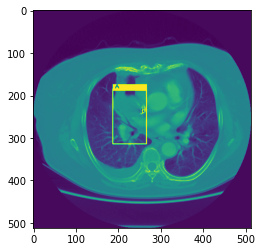

In [13]:
imax = ious.index(max(ious))
data = [np.hstack((np.asarray(ypred[imax]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasBestPred.png')

[array([192., 186., 270., 313.,   1.,   0.,   0.,   0.])]


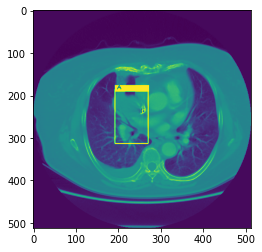

In [14]:
imax = ious.index(max(ious))
data = [np.hstack((np.asarray(y_test_box[imax]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imax]*255
img_bitmap = img_bitmap.reshape((512,512))
print(data)
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasActualBestPred.png')

[157. 336. 215. 385.] [148.41924 199.95142 206.35338 266.19208]


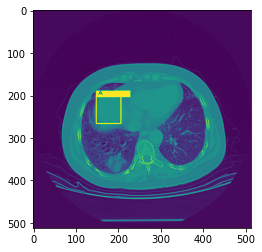

In [15]:
imin = ious.index(min(ious))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(ypred[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasWorstPred.png')

[157. 336. 215. 385.] [148.41924 199.95142 206.35338 266.19208]


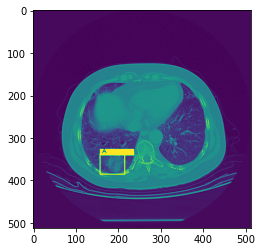

In [16]:
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(y_test_box[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])
plt.imshow(test)
plt.savefig('../myVisuals/kerasActualWorstPred.png')

[315. 273. 398. 415.] [254.40807 238.93481 358.32266 361.71417]


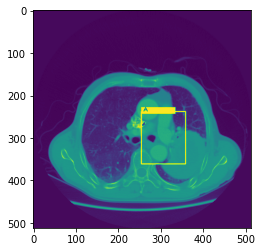

In [17]:
imin = hitious.index(min(hitious))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(ypred[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/kerasMediumPred.png')

[315. 273. 398. 415.] [254.40807 238.93481 358.32266 361.71417]


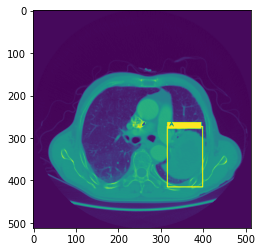

In [18]:
imin = hitious.index(min(hitious))
print(y_test_box[imin], ypred[imin])
data = [np.hstack((np.asarray(y_test_box[imin]), np.asarray([1,0,0,0])))]
img_bitmap = X_test[imin]*255
img_bitmap = img_bitmap.reshape((512,512))
test = roi2rect.roi2rect(img_name="test", img_np=img_bitmap, img_data=data, label_list=['A', 'B', 'D', 'G'])

plt.imshow(test)
plt.savefig('../myVisuals/kerasAtualMediumPred.png')